In [5]:
import pandas as pd
numerical_df = pd.read_csv("../dataset/cleaned_numerical_data.csv")
numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155361 entries, 0 to 155360
Data columns (total 45 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   nsites                                        155361 non-null  int64  
 1   nelements                                     155361 non-null  int64  
 2   volume                                        155361 non-null  float64
 3   density                                       155361 non-null  float64
 4   density_atomic                                155361 non-null  float64
 5   deprecated                                    155361 non-null  int64  
 6   energy_per_atom                               152149 non-null  float64
 7   formation_energy_per_atom                     152149 non-null  float64
 8   energy_above_hull                             152149 non-null  float64
 9   is_stable                                     15

In [6]:
#split data into real and theoretical subsets model on real values first

numerical_df.drop(['deprecated'], axis=1, inplace=True)

real_df = numerical_df[numerical_df['theoretical'] == 0].copy()
theoretical_df = numerical_df[numerical_df['theoretical'] == 1].copy()

real_df.drop(['theoretical'], axis=1, inplace=True)
theoretical_df.drop(['theoretical'], axis=1, inplace=True)

print("Real df shape:", real_df.shape)
print("Theoretical df shape:", theoretical_df.shape)

Real df shape: (49772, 43)
Theoretical df shape: (105589, 43)


In [ ]:
real_df['total_magnetization'].describe()

#Note, total_magnetization is not normally distributed and is skewed right

count    4.958000e+04
mean     3.841016e+00
std      1.108420e+01
min      0.000000e+00
25%      2.000000e-07
50%      1.067050e-03
75%      2.156984e+00
max      3.200437e+02
Name: total_magnetization, dtype: float64

In [83]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49772 entries, 36 to 155336
Data columns (total 43 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   nsites                                        49772 non-null  int64  
 1   nelements                                     49772 non-null  int64  
 2   volume                                        49772 non-null  float64
 3   density                                       49772 non-null  float64
 4   density_atomic                                49772 non-null  float64
 5   energy_per_atom                               48674 non-null  float64
 6   formation_energy_per_atom                     48674 non-null  float64
 7   energy_above_hull                             48674 non-null  float64
 8   is_stable                                     49772 non-null  int64  
 9   equilibrium_reaction_energy_per_atom          23056 non-null  fl

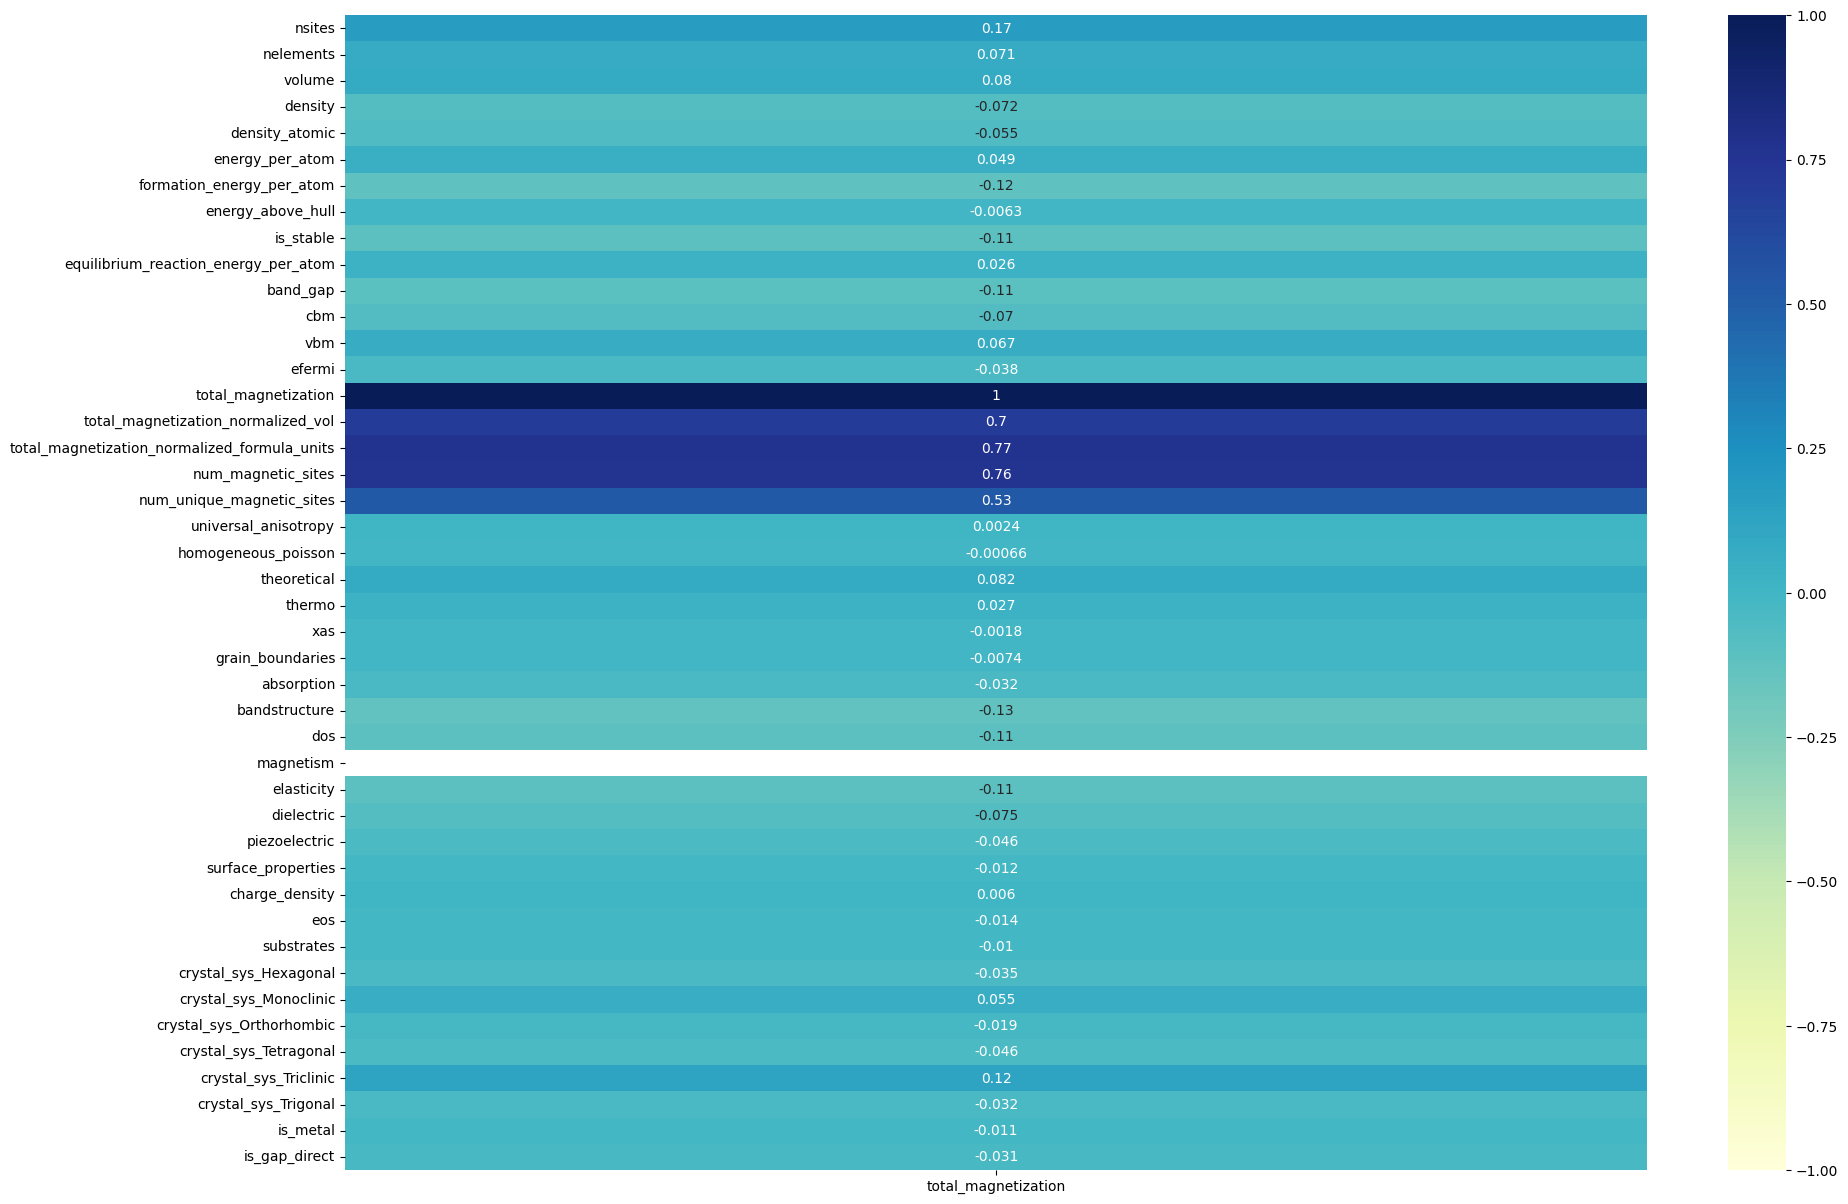

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(21, 15))
corr_matrix = numerical_df.corr()

corr_band_gap = corr_matrix[['total_magnetization']]
sns.heatmap(corr_band_gap, annot=True, cmap="YlGnBu", vmin=-1, vmax=1)

plt.show()

In [107]:
#Train a model for band_gap on real molecules

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

# Create the list of features to train with below
feature_names = [ "elasticity", "is_stable","nsites", "formation_energy_per_atom",
 "total_magnetization_normalized_formula_units","num_magnetic_sites","num_unique_magnetic_sites" ]

# numerical_df[feature_names].isnull().sum()

filtered_null_counts = numerical_df.loc[numerical_df['theoretical'] == 1, feature_names].isnull().sum()

print(filtered_null_counts)


elasticity                                         0
is_stable                                          0
nsites                                             0
formation_energy_per_atom                       2114
total_magnetization_normalized_formula_units     790
num_magnetic_sites                               790
num_unique_magnetic_sites                        790
dtype: int64


In [94]:
real_df['total_magnetization'].value_counts()
real_df['total_magnetization'].fillna('0.000000e+00', inplace=True)

<ipython-input-94-b7586fdc9443>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.000000e+00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  real_df['total_magnetization'].fillna('0.000000e+00', inplace=True)


In [108]:
X = real_df[feature_names]

y = real_df["total_magnetization"]

train_X, test_x, train_y, test_y = train_test_split(X, y, train_size = 0.2, random_state=1)

dtr_model = DecisionTreeRegressor(random_state=1)

dtr_model.fit(train_X, train_y)

predictions = dtr_model.predict(test_x)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_y, predictions)

# mean squared error (MSE) and R-squared (R2)
mse = mean_squared_error(test_y, predictions)
r2 = r2_score(test_y, predictions)

print("Mean Squared Error: ", mse)
print("R-squared: ", r2)
print("Mean Absolute Error: ", mae)

Mean Squared Error:  32.41164065512267
R-squared:  0.7338203972865722
Mean Absolute Error:  1.2664999698231847


In [109]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

#Check for and handle categorical variables
label_encoder = LabelEncoder()

# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=250, random_state=42, oob_score=True)
# train_X, val_X, train_y, val_y
regressor.fit(train_X, train_y)
# Fit the regressor with x and y data

RandomForestRegressor(n_estimators=250, oob_score=True, random_state=42)

In [ ]:
# Evaluating the model against the test set
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error


# OOB Score is the number of correctly predicted data on OOB samples taken for validation, you want less than 1%
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')


# Making predictions on the same data or new data
predictions = regressor.predict(test_x)

# Evaluating the model
mse = mean_squared_error(test_y, predictions)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(test_y, predictions)
print(f'R-squared: {r2}')

# using mae, mean absolute error, or the average error, we can see on average how far off our # model is

mae = mean_absolute_error(test_y, predictions)
print("Mean Absolute Error: ", mae)

Out-of-Bag Score: 0.8305243632607053
Mean Squared Error: 17.619111898026848
R-squared: 0.8553035850581361
Mean Absolute Error:  0.9847617845546451


In [98]:
# Replace NaN values in the entire DataFrame with the mean of each column
theoretical_df[feature_names] = theoretical_df[feature_names].fillna(theoretical_df[feature_names].mean())
theoretical_df = theoretical_df.dropna(subset=['total_magnetization'])

In [ ]:
#Now predict band-gap with the theoretical elements with Random Forrest Regressor

theoretical_x = theoretical_df[feature_names]
theoretical_y = theoretical_df['total_magnetization']

theoretical_predictions = regressor.predict(theoretical_x)

# Evaluating the model
mse = mean_squared_error(theoretical_y, theoretical_predictions)
mae = mean_absolute_error(theoretical_y, theoretical_predictions)
r2 = r2_score(theoretical_y, theoretical_predictions)

print(f'Mean Squared Error: {mse}')
print("Mean Absolute Error: ", mae)
print(f'R-squared: {r2}')

Mean Squared Error: 32.8744690281348
Mean Absolute Error:  2.0398035912544024
R-squared: 0.7987268844381675
